In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/500034/500034.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping

2024-05-12 04:16:06.143377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 04:16:06.143483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 04:16:06.315702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/500034/500034.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [4]:
plt.rcParams['figure.figsize'] = (20,10)

In [5]:
df['Open Price'] = df['Open Price'].shift(1)
df['High Price'] = df['High Price']
df['Low Price'] = df['Low Price']
df.sort_index(inplace = True)
interest = df[['Close Price','Open Price','High Price','Low Price']].values

In [6]:
interest

array([[ 481.85,  490.  ,  499.  ,  477.  ],
       [ 497.35,  500.  ,  500.  ,  485.  ],
       [ 525.05,  525.05,  535.  ,  500.  ],
       ...,
       [6729.85, 6839.15, 7008.6 , 6691.4 ],
       [6827.4 , 6836.8 , 6839.15, 6710.45],
       [6931.05,     nan, 6972.4 , 6821.65]])

In [7]:
n_steps = 100
n_features = 4
buffer = 0

X = []
y = []

scaler = MinMaxScaler(feature_range=(0,1)) #

interest = scaler.fit_transform(interest)


for j in range(len(interest)-(n_steps + buffer)):
    X.append(interest[j:j+(n_steps)])
    y.append(interest[j+(n_steps + buffer)][0])

In [8]:
X,y = np.array(X), np.array(y)

stacked_model = Sequential()
stacked_model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
stacked_model.add(LSTM(100, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(100, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(100, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(100, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(100, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(50, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(50, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(50, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(50, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(50, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(50, activation='tanh', return_sequences=True))
stacked_model.add(LSTM(50, activation='tanh'))
stacked_model.add(Dense(1))
stacked_model.compile(optimizer='adam', loss='mse')


length = X.shape[0]
x_train, x_test = X[:int(length * 0.8)], X[int(length * 0.8):]
y_train, y_test = y[:int(length * 0.8)], y[int(length * 0.8):]

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
history=stacked_model.fit(x_train, y_train, epochs=2000, verbose = 0)
r2_score(stacked_model.predict(x_test), y_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


0.9484376266287855

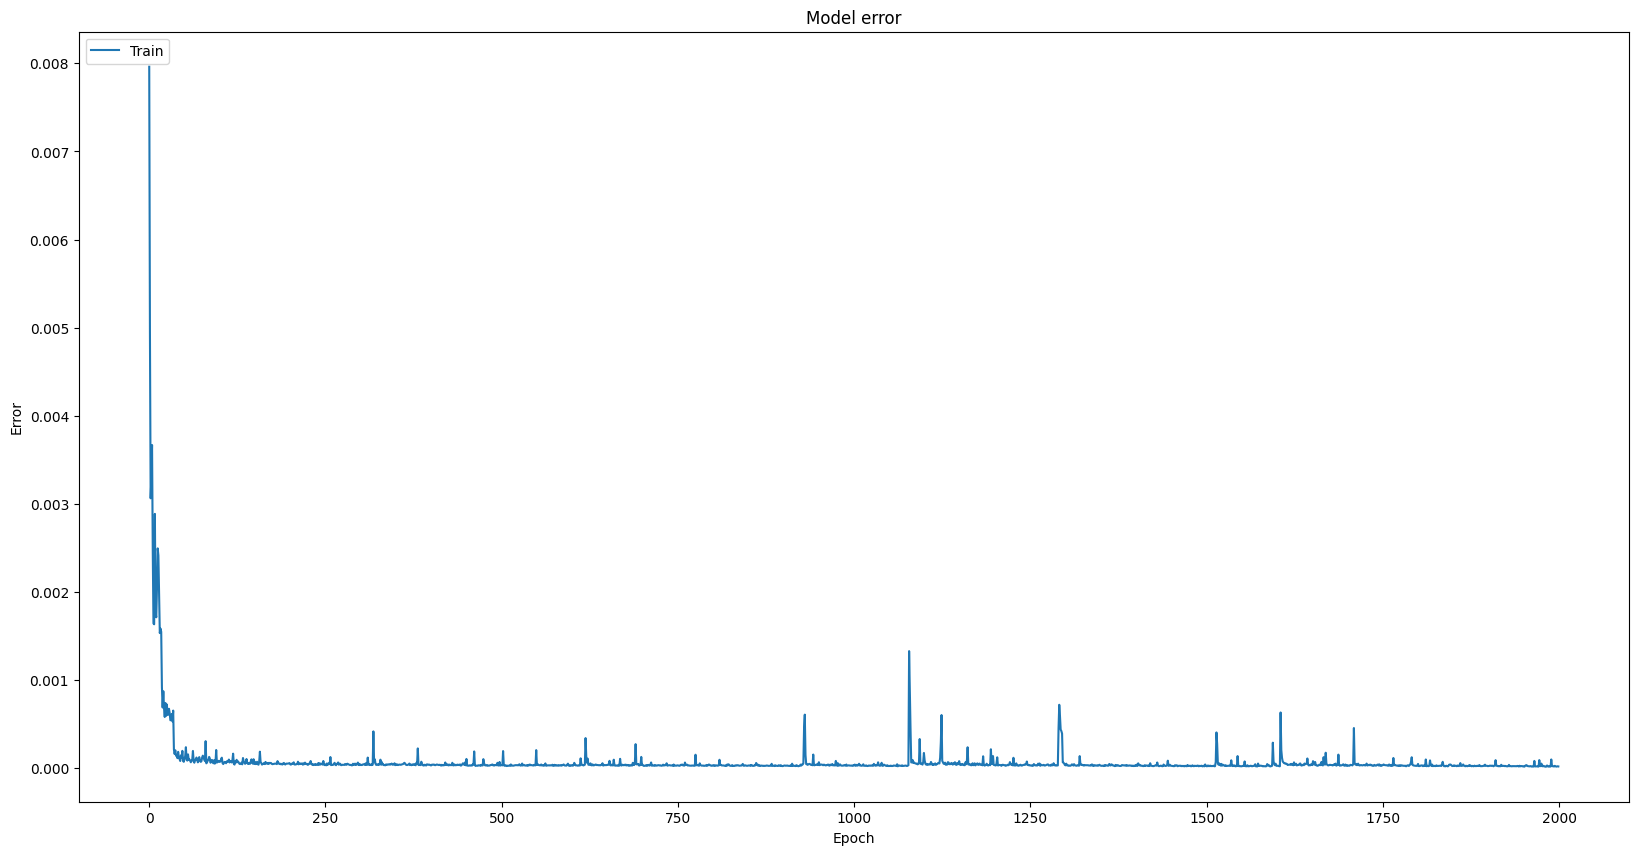

In [10]:
# prompt: plot the error encountered while training the stacked_model and also import the required library

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


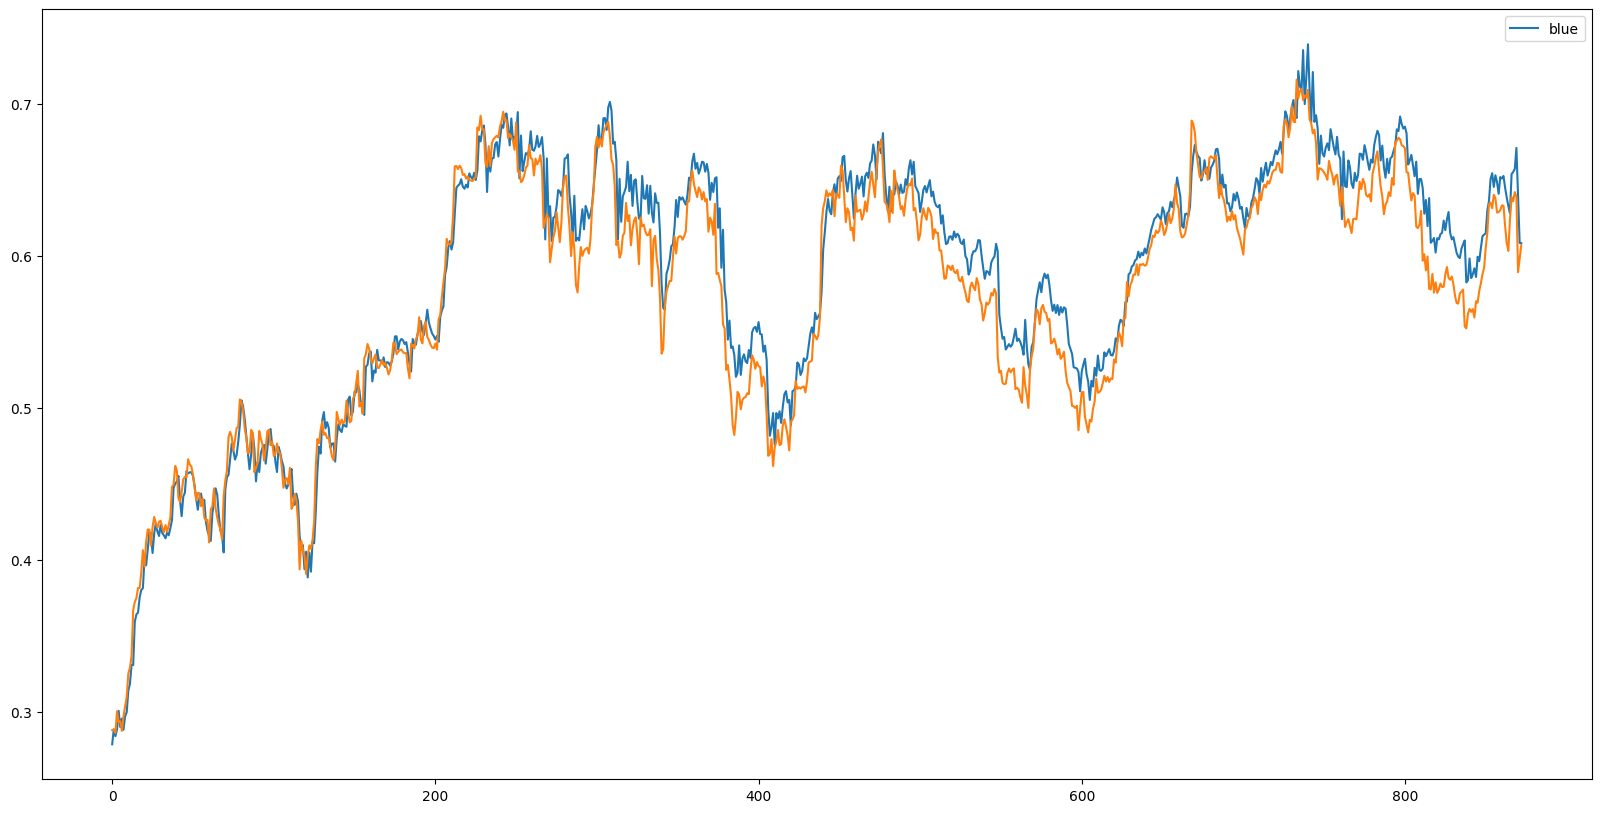

In [11]:
plt.plot(stacked_model.predict(x_test), label = 'blue')
plt.legend()
plt.plot(y_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


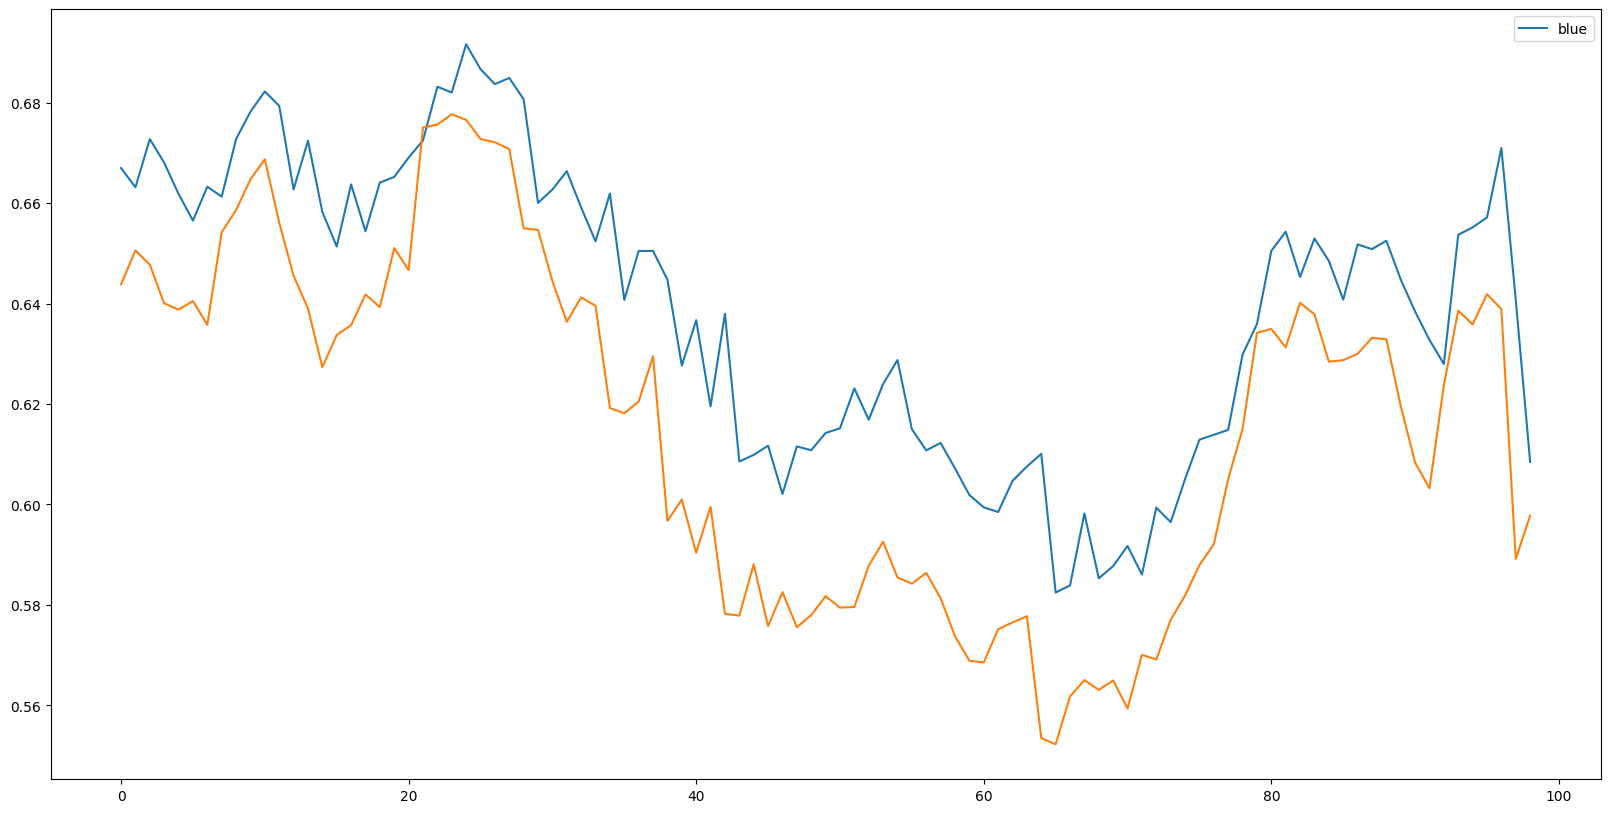

In [12]:
plt.plot(stacked_model.predict(x_test)[-100:-1:1], label = 'blue')
plt.plot(y_test[-100:-1:1])
plt.legend()

In [13]:
stacked_model.save("500034")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=500034.